In [101]:
import os

import joblib
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the Dataset

In [102]:
pillow_image = Image.open(
    "/Users/Bilal/PycharmProjects/LearningAI/Files/assignment_7/task_2/chest_xray/train/NORMAL/IM-0117-0001.jpeg")
image_array = np.array(pillow_image)
print(image_array.shape)

(1152, 1422)


In [103]:
SAVE_DIR = "/Users/Bilal/PycharmProjects/LearningAI/models/assignment_7/task_2"
MODEL_PATH = f"{SAVE_DIR}/pneumonia_model.keras"
HISTORY_PATH = f"{SAVE_DIR}/history.pkl"

In [104]:
# Set the seed
tf.random.set_seed(42)

# Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1. / 255)

valid_datagen = ImageDataGenerator(rescale=1. / 255)

In [105]:
train_dir = "/Users/Bilal/PycharmProjects/LearningAI/Files/assignment_7/task_2/chest_xray/train"
test_dir = "/Users/Bilal/PycharmProjects/LearningAI/Files/assignment_7/task_2/chest_xray/test"

In [106]:
train_data = train_datagen.flow_from_directory(
    train_dir,
    color_mode="grayscale",
    batch_size=32,
    target_size=(224, 224),
    class_mode="binary"
)

test_data = valid_datagen.flow_from_directory(
    test_dir,
    color_mode="grayscale",
    batch_size=32,
    target_size=(224, 224),
    class_mode="binary",
    shuffle=False
)



Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [107]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])


In [108]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 1)),
    data_augmentation,

    tf.keras.layers.Conv2D(32, (3, 3), padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2),

    tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2),

    tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(1, activation="sigmoid")
])


In [109]:
model.compile(loss=tf.keras.losses.binary_crossentropy, optimizer='adam', metrics=["accuracy"])

In [110]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=MODEL_PATH,
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)


Making a new Model
Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - accuracy: 0.7121 - loss: 2.5234
Epoch 1: val_accuracy improved from None to 0.76442, saving model to /Users/Bilal/PycharmProjects/LearningAI/models/assignment_7/task_2/pneumonia_model.keras

Epoch 1: finished saving model to /Users/Bilal/PycharmProjects/LearningAI/models/assignment_7/task_2/pneumonia_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 117s 711ms/step - accuracy: 0.7983 - loss: 0.9183 - val_accuracy: 0.7644 - val_loss: 0.4752
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 658ms/step - accuracy: 0.8515 - loss: 0.3250
Epoch 2: val_accuracy improved from 0.76442 to 0.86699, saving model to /Users/Bilal/PycharmProjects/LearningAI/models/assignment_7/task_2/pneumonia_model.keras

Epoch 2: finished saving model to /Users/Bilal/PycharmProjects/LearningAI/models/assignment_7/task_2/pneumonia_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 111s 680ms/step - accuracy: 0.8815 - loss: 0.2767 - val_accuracy: 0.8670 - val_loss: 0.321

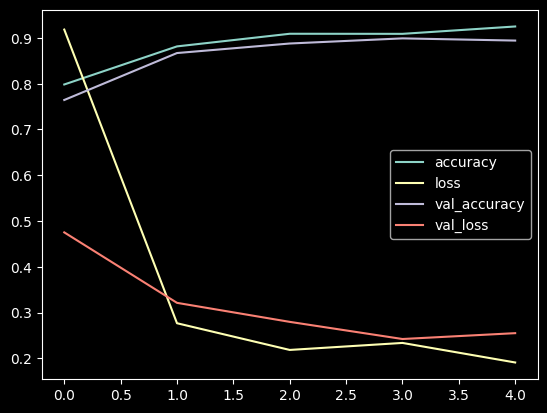

In [111]:
if os.path.exists(MODEL_PATH) and os.path.exists(HISTORY_PATH):
    print("Loading Already Present Model")
    model = tf.keras.models.load_model(MODEL_PATH)
    history = joblib.load(HISTORY_PATH)

    print("Final Training Accuracy:", history["accuracy"][-1])
    print("Final Validation Accuracy:", history["val_accuracy"][-1])

    #evaulation
    pd.DataFrame(history).plot()

else:
    print("Making a new Model")

    history = model.fit(train_data, epochs=5, steps_per_epoch=len(train_data), validation_data=test_data,
                        callbacks=[checkpoint])
    model.save(MODEL_PATH)
    #savng history
    joblib.dump(history.history, HISTORY_PATH)

    print("Final Training Accuracy:", history.history["accuracy"][-1])
    print("Final Validation Accuracy:", history.history["val_accuracy"][-1])

    #evaluation
    pd.DataFrame(history.history).plot()

In [112]:

y_prob = model.predict(test_data)
# Convert probabilities to 0 or 1
y_pred = (y_prob >= 0.5).astype(int)

# Get true labels
y_true = test_data.classes  # works if using flow_from_directory


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step


In [113]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.84      0.88      0.86       234
           1       0.93      0.90      0.91       390

    accuracy                           0.89       624
   macro avg       0.89      0.89      0.89       624
weighted avg       0.90      0.89      0.89       624

